In [26]:
# 1. Kütüphaneler ve Ayarlar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import time, copy, os
from collections import Counter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
SEED = 42
DATA_DIR = 'C:/Users/Muhammet/Desktop/DerinÖğrenme_Projesi/archive/Multi-class Weather Dataset'

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(SEED)


✅ Kullanılan Cihaz: cuda:0


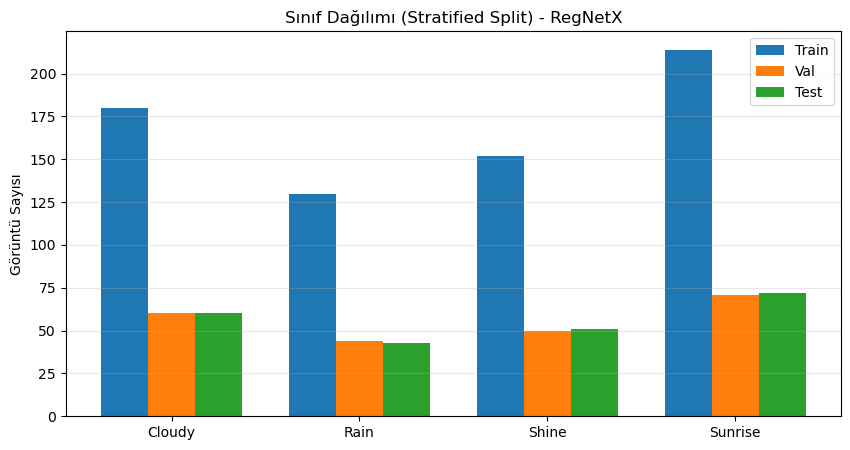

📂 Sınıflar: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
📊 Dağılım: Train=676, Val=225, Test=226


In [27]:
# 2. Veri Yükleme, Augmentation ve STRATIFIED SPLIT
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

try:
    full_dataset = datasets.ImageFolder(DATA_DIR, transform=None)
except FileNotFoundError:
    print("❌ HATA: Veri yolu bulunamadı.")

targets = full_dataset.targets

train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.4,
    shuffle=True, stratify=targets, random_state=SEED
)

temp_targets = np.array(targets)[temp_idx]

val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5,
    shuffle=True, stratify=temp_targets, random_state=SEED
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

def count_classes_subset(dataset, full_targets):
    indices = dataset.indices
    labels = [full_targets[i] for i in indices]
    return Counter(labels)

train_c = count_classes_subset(train_dataset, full_dataset.targets)
val_c   = count_classes_subset(val_dataset, full_dataset.targets)
test_c  = count_classes_subset(test_dataset, full_dataset.targets)

x = np.arange(NUM_CLASSES)
w = 0.25
class_names = full_dataset.classes

plt.figure(figsize=(10,5))
plt.bar(x-w, [train_c[i] for i in range(NUM_CLASSES)], w, label="Train")
plt.bar(x,   [val_c[i]   for i in range(NUM_CLASSES)], w, label="Val")
plt.bar(x+w, [test_c[i]  for i in range(NUM_CLASSES)], w, label="Test")
plt.xticks(x, class_names)
plt.ylabel("Görüntü Sayısı")
plt.title("Sınıf Dağılımı (Stratified Split) - RegNetX")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformDataset(train_dataset, transform=train_transform)
val_dataset   = TransformDataset(val_dataset, transform=val_test_transform)
test_dataset  = TransformDataset(test_dataset, transform=val_test_transform)

use_pin_memory = device.type == 'cuda'
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=use_pin_memory),
    'val':   DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0, pin_memory=use_pin_memory),
    'test':  DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0, pin_memory=use_pin_memory),
}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx), 'test': len(test_idx)}

print(f"📂 Sınıflar: {class_names}")
print(f"📊 Dağılım: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")


In [28]:
# 3. Model: RegNetX-8GF
print("📥 RegNetX-8GF Modeli Yükleniyor...")

model_ft = models.regnet_x_8gf(weights='DEFAULT')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)


📥 RegNetX-8GF Modeli Yükleniyor...


Epoch 1/20 | Train Loss: 0.6746 Acc: 0.8328 | Val Loss: 0.1288 Acc: 0.9600
Epoch 2/20 | Train Loss: 0.1291 Acc: 0.9586 | Val Loss: 0.0709 Acc: 0.9778
Epoch 3/20 | Train Loss: 0.0758 Acc: 0.9822 | Val Loss: 0.0475 Acc: 0.9867
Epoch 4/20 | Train Loss: 0.0513 Acc: 0.9808 | Val Loss: 0.0762 Acc: 0.9733
Epoch 5/20 | Train Loss: 0.0414 Acc: 0.9882 | Val Loss: 0.0435 Acc: 0.9867
Epoch 6/20 | Train Loss: 0.0441 Acc: 0.9896 | Val Loss: 0.0438 Acc: 0.9911
Epoch 7/20 | Train Loss: 0.0284 Acc: 0.9911 | Val Loss: 0.0593 Acc: 0.9867
Epoch 8/20 | Train Loss: 0.0178 Acc: 0.9956 | Val Loss: 0.0360 Acc: 0.9867
Epoch 9/20 | Train Loss: 0.0221 Acc: 0.9926 | Val Loss: 0.0640 Acc: 0.9822
Epoch 10/20 | Train Loss: 0.0180 Acc: 0.9970 | Val Loss: 0.0477 Acc: 0.9778
Epoch 11/20 | Train Loss: 0.0119 Acc: 0.9985 | Val Loss: 0.0631 Acc: 0.9778
Epoch 12/20 | Train Loss: 0.0281 Acc: 0.9926 | Val Loss: 0.0639 Acc: 0.9778
Epoch 13/20 | Train Loss: 0.0276 Acc: 0.9956 | Val Loss: 0.0209 Acc: 0.9911
Epoch 14/20 | Train L

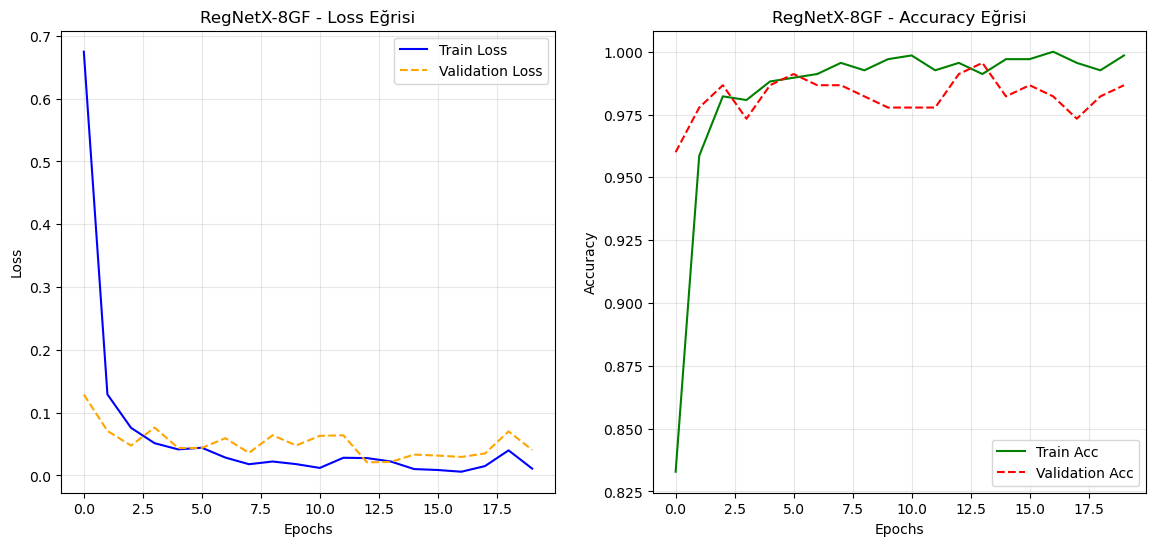

In [29]:
# 4. Eğitim ve Grafikler
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}', end=' ')
        
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                print(f'| Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end=' ')
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                print(f'| Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\n🏆 En İyi Val Accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

model_ft, hist = train_model(model_ft, criterion, optimizer_ft, NUM_EPOCHS)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(hist['train_loss'], label='Train Loss', color='blue')
plt.plot(hist['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('RegNetX-8GF - Loss Eğrisi')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(hist['train_acc'], label='Train Acc', color='green')
plt.plot(hist['val_acc'], label='Validation Acc', color='red', linestyle='--')
plt.title('RegNetX-8GF - Accuracy Eğrisi')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


In [32]:
# 5. Detaylı Performans Analizi (RegNet) — VERİ HAZIRLAMA
def evaluate_prepare(model, dataloader):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    print("\n--- Test Seti Değerlendirmesi Başlıyor ---")
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    return y_true, y_pred, y_score

# ÇALIŞTIR → sonuçları değişkenlere kaydet
y_true, y_pred, y_score = evaluate_prepare(model_ft, dataloaders['test'])



--- Test Seti Değerlendirmesi Başlıyor ---


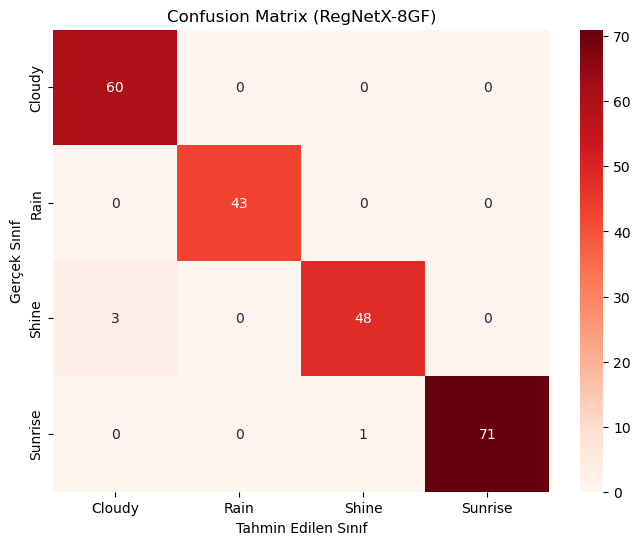

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (RegNetX-8GF)")
plt.ylabel("Gerçek Sınıf")
plt.xlabel("Tahmin Edilen Sınıf")
plt.show()


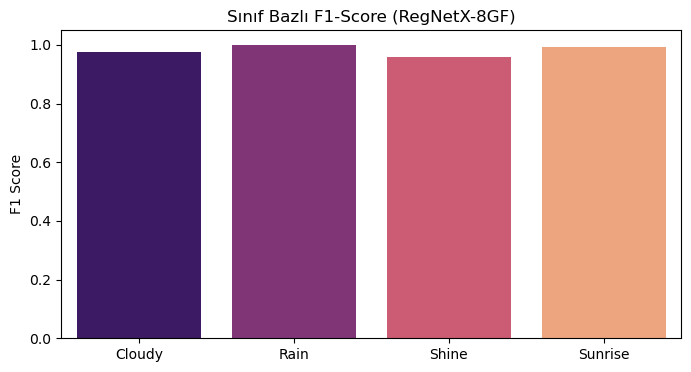

In [36]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True
)

f1_scores = [report[c]['f1-score'] for c in class_names]

plt.figure(figsize=(8,4))

# ✓ hue ekledik — legend kapattık → FutureWarning gider
sns.barplot(
    x=class_names,
    y=f1_scores,
    hue=class_names,
    palette="magma",
    legend=False
)

plt.ylim(0, 1.05)
plt.ylabel("F1 Score")
plt.title("Sınıf Bazlı F1-Score (RegNetX-8GF)")
plt.show()



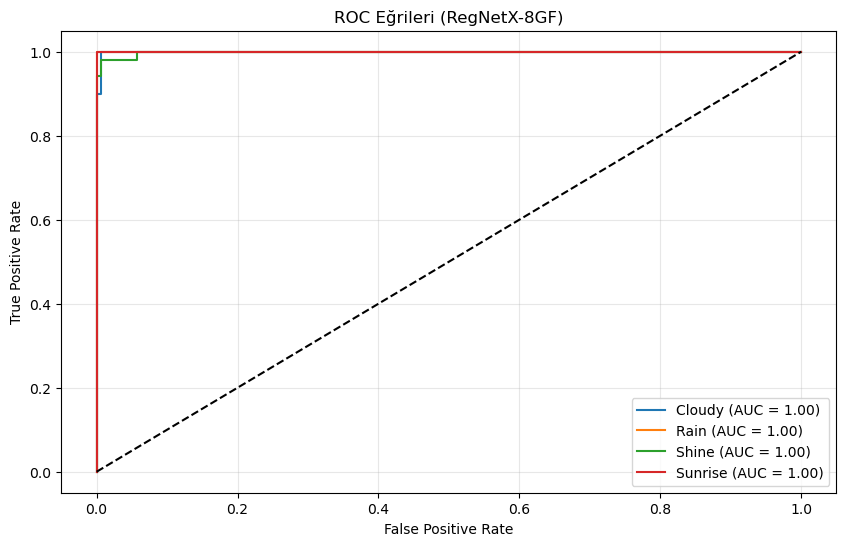

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(10,6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri (RegNetX-8GF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


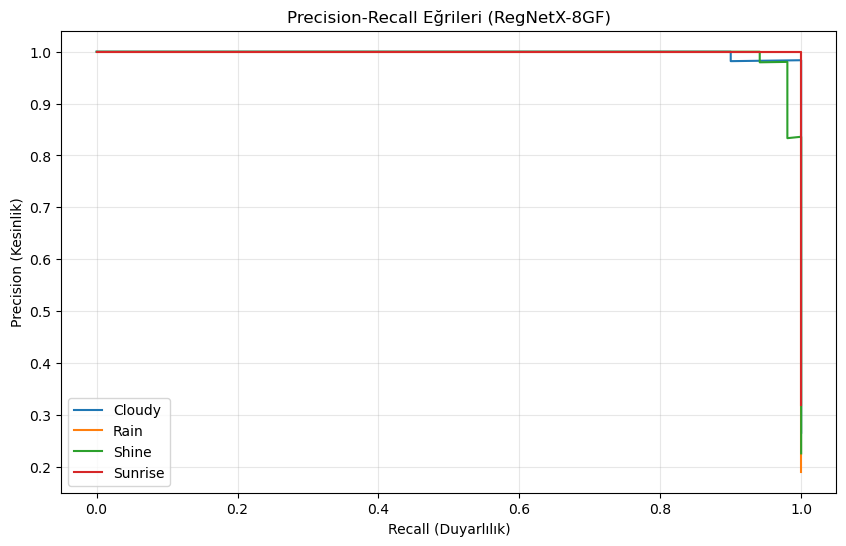

In [37]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10,6))
for i in range(len(class_names)):
    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    plt.plot(r, p, label=f"{class_names[i]}")

plt.xlabel("Recall (Duyarlılık)")
plt.ylabel("Precision (Kesinlik)")
plt.title("Precision-Recall Eğrileri (RegNetX-8GF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



--- Model Tahmin Örnekleri (Rastgele 8 Adet) ---


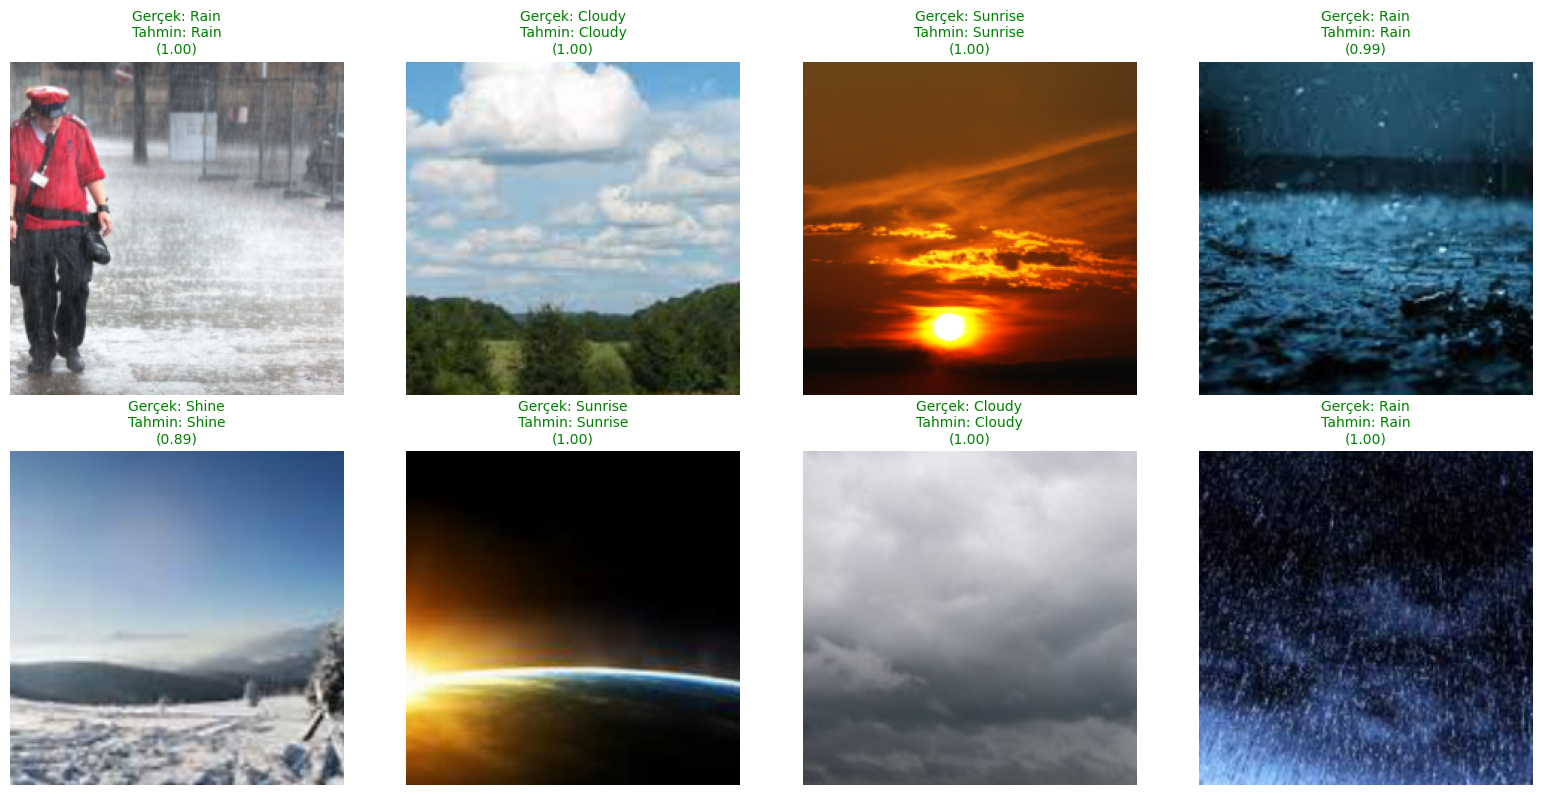


🎉 TEBRİKLER! RegNetX-8GF süreci tamamlandı.


In [38]:
# 6. Görsel Tahminler (Grid)
def show_sample_predictions(model, dataset, classes, n=8):
    model.eval()
    idxs = np.random.choice(len(dataset), n, replace=False)

    fig = plt.figure(figsize=(16, 8))
    for i, idx in enumerate(idxs):
        image, label = dataset[idx]

        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            conf, pred_idx = torch.max(probs, 1)

        pred_label = classes[pred_idx.item()]
        true_label = classes[label]

        img_np = image.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(img_np)
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\n({conf.item():.2f})",
                  color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n--- Model Tahmin Örnekleri (Rastgele 8 Adet) ---")
show_sample_predictions(model_ft, test_dataset, class_names, n=8)

print("\n🎉 TEBRİKLER! RegNetX-8GF süreci tamamlandı.")
